In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import resample_poly
from sklearn.linear_model import LinearRegression
import yaml
from scipy.ndimage import gaussian_filter1d

In [44]:
data_dir = r'Y:\\public\\projects\SaEl_20220201_VIP\\2pdata\subj_record_silence.xlsx'
# Load Excel file using pandas
sheet_name = 'RSC_axon'
table = pd.read_excel(data_dir, sheet_name=sheet_name)
ani=15

suite2ppath = table.iloc[ani][5]  # Assuming the column name is 'path'
behavior_data_path = table.iloc[ani][2]  # Replace 'behavior_data_path' with the correct column name
# folder_path =  r'Y:\\public\\projects\SaEl_20220201_VIP\\2pdata\\RSCaxonimaging\se067\AB\\behavior_data'
analog_file = os.path.join(behavior_data_path,'AnalogInput.bin')
analog_data = np.fromfile(analog_file, dtype=np.float64).reshape(-1,2).transpose()
fs_analog = 1000 #samples per second
analog_time = np.arange(analog_data[0,:].shape[0])/fs_analog

digital_file = os.path.join(behavior_data_path,'DigitalInput.bin')
digital_data = np.fromfile(digital_file, dtype=np.byte)
fs_digital = 3000 #samples per second
digital_time = np.arange(digital_data.shape[0])/fs_digital

encoder_csv_data = pd.read_csv(os.path.join(behavior_data_path,'RotaryEncoder.csv') )
vr_csv_data = pd.read_csv(os.path.join(behavior_data_path,'VrPosition.csv') )
events_csv_data = pd.read_csv(os.path.join(behavior_data_path,'FrameEvents.csv') )
counter_csv_data = pd.read_csv(os.path.join(behavior_data_path,'FrameCounter.csv') )
quadsync_csv_data = pd.read_csv(os.path.join(behavior_data_path, 'QuadSynch.csv'))
log_file = os.path.join(behavior_data_path,'TrialLogging.yaml')

In [6]:
# define fxns for aligning and extracting data
def extract_digital_channel(digital_data, channel_number):
     #channel_number goes from 0 to 7
     return digital_data & (1 << channel_number) > 0

def detect_edges(signal):
    edges =np.where(np.diff(signal) == 1)[0] +1# identify where in time frame signal
    return edges

def detect_rising_edges(signal):
    edges = np.where((np.diff(signal) > 0) & (signal[1:] == 1))[0] + 1 # identify where in time frame signal
    return edges

def align_signal_to_frames(signal_times, photodiode_time):
    aligned_times = []
    aligned_indices = []
    for signal_time in signal_times:
        next_frame_indices = np.where(photodiode_time > signal_time)[0]
        if len(next_frame_indices) > 0:
            aligned_index = next_frame_indices[0]
            aligned_time = photodiode_time[aligned_index]
        else:
            #can't align so ignore
            continue
        
        aligned_times.append(aligned_time)
        aligned_indices.append(aligned_index)
    
    return np.array(aligned_times), np.array(aligned_indices)

def extract_trial_type(filename,label):
    with open(filename, 'r') as f:
        yaml_string = f.read()
    
    trial_strings = yaml_string.strip().split('\n\n') 
    trial_type_labels = []
    for trial_string in trial_strings:
        trial = yaml.safe_load(trial_string)
        if label in trial:
            trial_type_labels.append(trial[label])
    return trial_type_labels

# Function to load Suite2P data and calculate DFF & Z-score
def process_suite2p_data(suite2ppath):
    # Load Suite2P options
    ops = np.load(os.path.join(suite2ppath, f'plane0','ops.npy'), allow_pickle=True).item()
    # Initialize lists to store data from all planes
    dF_F = []
    all_cells_indices = []
    # Loop through all planes
    n_planes = ops['nplanes']

    for plane_num in range(n_planes):
        smooth_window = 3
        # Load fluorescence traces (dF/F) and neuropil traces for the current plane
        plane_path = os.path.join(suite2ppath, f'plane{plane_num}')
        F = np.load(os.path.join(plane_path, 'F.npy'))
        Fneu = np.load(os.path.join(plane_path, 'Fneu.npy'))

        # Load the iscell.npy file to get information about which ROIs are cells
        iscell = np.load(os.path.join(plane_path, 'iscell.npy'))
        cells_indices = np.where(iscell[:, 0])[0]

        # Smooth trace
        TC = F - 0.3 * Fneu
        TC_smoothed = gaussian_filter1d(TC, sigma=smooth_window, axis=0)

        # Perform further processing for the current plane
        baseline = np.percentile(TC_smoothed, 50, axis=1)
        TC_dff = TC_smoothed / baseline[:, None]
        TC_dff_Zscore = (TC_dff - np.nanmean(TC_dff, axis=0)) / np.nanstd(TC_dff, axis=0)

        # Append the processed data for the current plane to the lists
        dF_F.append(TC_dff_Zscore)
        all_cells_indices.append(cells_indices)
        
    max_columns = max(array.shape[1] for array in dF_F) # max num of columns

    for i in range(len(dF_F)): #pad arrays with fewer columns than the maximum with NaN values
        if dF_F[i].shape[1] < max_columns:
            padding_size = max_columns - dF_F[i].shape[1]
            dF_F[i] = np.hstack([dF_F[i], np.full((dF_F[i].shape[0], padding_size), np.nan)])

    dF_F = np.vstack(dF_F)
    # Return the processed data for all planes
    return ops, dF_F, cells_indices, n_planes

def find_significant_neurons(z_score, grating_indices, pre_stim_slice, post_stim_slice, trial_id, early_subset, threshold):
    significant_neurons = {}
    trial_subset = trial_id[early_subset]
    stim_periods = {}

    for grating, indices in grating_indices.items():
        stim_periods= [indices[idx] for idx in trial_subset if idx < len(indices)]
        avg_z_pre_stim_list = []
        avg_z_post_stim_list = []
        
        for trial in range(len(stim_periods)):
            avg_z_pre_stim_list.append(np.mean(z_score[:, stim_periods[trial][pre_stim_slice]], axis=1))
            avg_z_post_stim_list.append(np.mean(z_score[:, stim_periods[trial][post_stim_slice]], axis=1))

        # Averaging over trials for each neuron
        avg_z_pre_stim = np.median(avg_z_pre_stim_list, axis=0)
        avg_z_post_stim = np.median(avg_z_post_stim_list, axis=0)
        
        z_diff = avg_z_post_stim - avg_z_pre_stim
        sig_neurons = np.where(z_diff > threshold)[0]
        significant_neurons[grating] = list(sig_neurons)

    return significant_neurons

def decimate_dataframe(df, nz, binary_cols=[], event_cols=[]):
    
    # Detecting rising edges in the signal.
    rising_edges = np.where(df['Scanner_Signal'].values == 1)[0]
    # Aggregate time-points of frames from different z-planes.
    start_idx = rising_edges[::nz]
    # Ensure that we have a "stop" for each "start".
    if len(start_idx) > 1:
        stop_idx = start_idx[1:] - 1
        stop_idx = np.append(stop_idx, [len(df) - 1])  # Add the very last index for the last chunk
    else:
        stop_idx = [len(df) - 1]
        
    # Use a list to store the results
    results = []
    for start, stop in zip(start_idx, stop_idx):
        chunk = df.iloc[start:stop+1].copy()  # +1 to include the falling edge row
        avg_data = {}
        for col in df.columns:
            if col in binary_cols:
                avg_data[col] = int(chunk[col].sum() > 0)  # Logical OR for binary columns.
            elif col in event_cols:
                avg_data[col] = chunk[col].max()  # Extracting the first non-zero value.
            else:
                avg_data[col] = chunk[col].mean()

        results.append(avg_data)
    # Convert results to DataFrame
    decimated_df = pd.DataFrame(results)
    return decimated_df

def align_frames(downsampled_data, dff_Zscore):
    # Check if the number of detected frames matches the number of frames in roi_array
    excess_frames = dff_Zscore.shape[1] - len(downsampled_data)
    
    if excess_frames > 0:
        print(f"Detected {excess_frames} excess frames in the acquisition data (dff_Zscore). Trimming these frames.")
        dff_Zscore = dff_Zscore[:, :-excess_frames]
    elif excess_frames < 0:
        raise ValueError("Mismatch detected: More frames in downsampled data than in ROI acquisition data.")
    
    return downsampled_data, dff_Zscore

def check_data(behavior_data_path, data,n_planes):
    data_path = os.path.join(behavior_data_path, 'data.pkl')
    if not os.path.exists(data_path):
        print("data not found. Processing data...")

        downsampled_data=decimate_dataframe(data,nz=n_planes,binary_cols=['Lick'],event_cols=['Stim','Lap_Start'])
        downsampled_data.to_pickle(os.path.join(behavior_data_path, 'data.pkl')) #save data
    else:
        print("data found. Loading existing data...")
        downsampled_data = pd.read_pickle(data_path)
    return downsampled_data

In [ ]:
ops, dff_Zscore, cells_indices, n_planes = process_suite2p_data(suite2ppath)

In [45]:
# ensure that photodiode and gpu toggle signal are aligned 
photodiode_signal = extract_digital_channel(digital_data, 2)
gpu_toggle_time = quadsync_csv_data["Time"].values
diode_time = detect_edges(photodiode_signal)/fs_digital
min_nidaq_sample = 10_000
first_diode_time = diode_time[diode_time > (min_nidaq_sample/fs_digital)][0]
allowed_error = 0.010

gpu_v_photodiode = np.empty((gpu_toggle_time.shape[0], 2))
for synch_idx, gpu_t in enumerate(gpu_toggle_time):
    if synch_idx == 0:
        gpu_v_photodiode[synch_idx, 0] = gpu_t
        gpu_v_photodiode[synch_idx, 1] = first_diode_time
    else:
        expected_delta = gpu_t - gpu_v_photodiode[synch_idx-1, 0]
        expected_diode_time = gpu_v_photodiode[synch_idx-1, 1] + expected_delta
        argmin = np.argmin(abs(diode_time - expected_diode_time))
        gpu_v_photodiode[synch_idx, 0] = gpu_t
        gpu_v_photodiode[synch_idx, 1] = diode_time[argmin]

        # if abs(diode_time[argmin] - expected_diode_time) > allowed_error:
        #     print(diode_time[argmin] - expected_diode_time) 
        #     gpu_v_photodiode[synch_idx, 1] = 0
        # else:
        #     gpu_v_photodiode[synch_idx, 1] = diode_time[argmin]

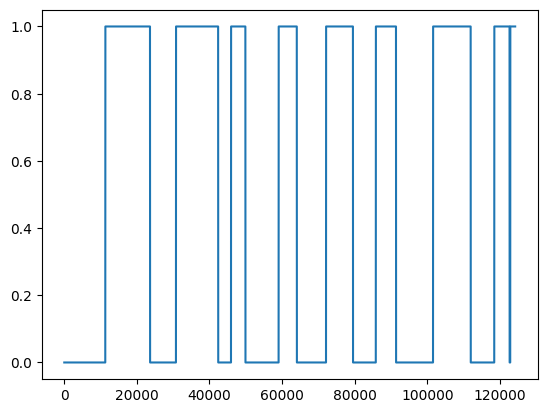

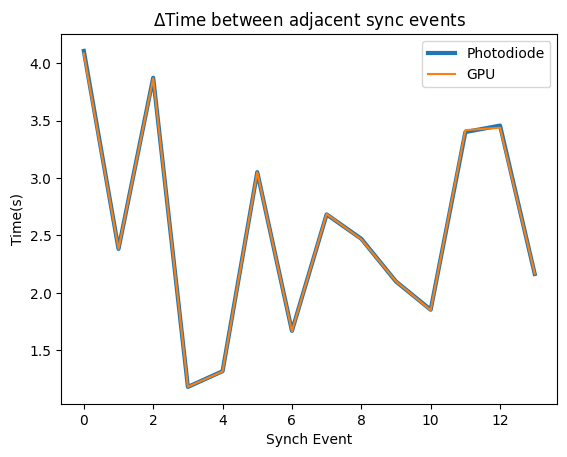

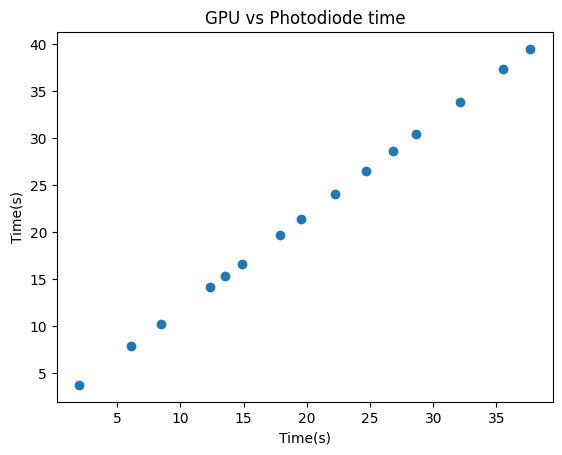

R2=0.9999996354849192 ---- Slope=1.000607017407521 ---- intercept=1.7748095930409988


In [46]:
# visualize photodiode toggle
plt.figure()
plt.plot(photodiode_signal)
plt.show()

# sync events should be aligned for gpu and photodiode
plt.figure()
plt.plot(np.diff(gpu_v_photodiode[:,1]), label="Photodiode", lw=3)
plt.plot(np.diff(gpu_v_photodiode[:,0]), label="GPU")

plt.title("$\Delta$Time between adjacent sync events")
plt.xlabel("Synch Event")
plt.ylabel("Time(s)")
plt.legend()
plt.show()

# Calculate the regression that takes you Time(GPU) -> Time(NIDAQ)
plt.figure()
plt.scatter(gpu_v_photodiode[:,0], gpu_v_photodiode[:,1])
plt.title("GPU vs Photodiode time")
plt.xlabel("Time(s)")
plt.ylabel("Time(s)")
plt.show()

reg = LinearRegression().fit(gpu_v_photodiode[:,0].reshape(-1, 1), gpu_v_photodiode[:,1])
r2 = reg.score(gpu_v_photodiode[:,0].reshape(-1, 1), gpu_v_photodiode[:,1])
slope = reg.coef_[0]
intercept = reg.intercept_
print(f"R2={r2} ---- Slope={slope} ---- intercept={intercept}")

gpu_2_photodiode_time = lambda gpu_time : gpu_time*slope + intercept
photodiode_2_gpu_time =  lambda photodiode_time : (photodiode_time - intercept)/ slope

In [47]:
#  apply regression func to every value in time to make sure that gpu time is converted to rendering time
counter_csv_data["Photodiode_Time"] = counter_csv_data["Time"].apply(gpu_2_photodiode_time)
events_csv_data["Photodiode_Time"] = events_csv_data["Frame.Time"].apply(gpu_2_photodiode_time)
vr_csv_data["Photodiode_Time"] = vr_csv_data["Time"].apply(gpu_2_photodiode_time)
encoder_csv_data["Photodiode_Time"] = encoder_csv_data["RenderElapsedTime"].apply(gpu_2_photodiode_time)
vr_csv_data=vr_csv_data.drop_duplicates(subset=['Photodiode_Time'],keep='last')
#  calculate speed in real time and in tunnel
wheel_dim=0.157
encoder_csv_data['Speed_Absolute']=(encoder_csv_data['RotaryEncoder'].diff()*wheel_dim)/encoder_csv_data['Photodiode_Time'].diff()
encoder_csv_data['Speed_Absolute'].fillna(0,inplace=True)

# scanner digital data extraction
scanner_signal= extract_digital_channel(digital_data,0)
scanner_time =detect_rising_edges(scanner_signal)/fs_digital
aligned_scanner_times = gpu_2_photodiode_time(scanner_time)

# piezo analog data extraction
piezo_signal = analog_data[0,:] # specify input
piezo_time = np.arange(piezo_signal.shape[0])/fs_analog
aligned_piezo_times = gpu_2_photodiode_time(piezo_time)


In [48]:
data=pd.DataFrame()
data['Photodiode_Time']=counter_csv_data['Photodiode_Time']
data = data.merge(vr_csv_data[['Photodiode_Time','Position']],on='Photodiode_Time',how='left')
data = data.rename(columns={'Position':'Vr_Position'})
data = data.merge(encoder_csv_data[['Photodiode_Time','RotaryEncoder','Speed_Absolute']],on='Photodiode_Time',how='left')
data = data.rename(columns={'RotaryEncoder':'Encoder_Position'})
# nearest neighbor for analog piezo signal
indices = np.searchsorted(aligned_piezo_times, data['Photodiode_Time'])
indices = np.clip(indices, 0, len(piezo_signal) - 1)  #ensure within valid range for indices
data['Piezo_Signal'] = piezo_signal[indices]

lap_transitions=np.where(np.diff(vr_csv_data['Position']) < -4)[0] + 1
num_laps = len(lap_transitions) + 1

data['Lap_Start'] = 0
data.loc[lap_transitions, 'Lap_Start'] = 1

data = data.merge(events_csv_data[['Photodiode_Time','EventName','EventData']],on='Photodiode_Time',how='left')
data['Scanner_Signal'] = 0
for time in aligned_scanner_times:
    idx = (data['Photodiode_Time'] - time).abs().idxmin()
    data.at[idx, 'Scanner_Signal'] = 1

stim_onset = data[data['EventName'] == 'WallVisibility']
event_data_list = stim_onset['EventData'].tolist() # need to change so that I only readout the number
stim_value = []
for event in event_data_list:
    value = int(event.split('L')[1].split('R')[0])
    stim_value.append(value)
unique_stim_values = list(set(stim_value)) # implicitly defines number of gratings

data['Lick'] = (data['EventName'] == 'Lick').astype(int)
data['Stim'] = (data['EventName'] == 'WallVisibility').astype(int)
stim_indices = data[data['Stim'] == 1].index
data.loc[stim_indices, 'Stim'] = stim_value

data = data.drop(columns='EventName')
data = data.drop(columns='EventData')

downsampled_data = check_data(behavior_data_path, data, n_planes=2)
aligned_data, aligned_dff_Zscore = align_frames(downsampled_data,dff_Zscore)

data not found. Processing data...


In [49]:
n_gratings = 2
gratings_start = aligned_data[aligned_data['Stim'] != 0].index
trial_start_indices = aligned_data[aligned_data['Lap_Start'] == 1].index.tolist()
ntrial = len(extract_trial_type(log_file,'trialTypeLabel'))
trial_type = extract_trial_type(log_file,'trialTypeLabel')
stim_value = aligned_data[aligned_data['Stim'] != 0]['Stim']

trials = []
for i in range(len(trial_start_indices)-1):
    trial_data = aligned_data.iloc[trial_start_indices[i]:trial_start_indices[i + 1]]
    trials.append(trial_data)

gratings_start = aligned_data[aligned_data['Stim'] != 0].index
condition = (gratings_start > trial_start_indices[0]) & (gratings_start < trial_start_indices[-1])
gratings_start = gratings_start[condition]
stim_value = stim_value[condition]

grating_onsets_dict = {}
for idx in gratings_start:
    grating_num = (idx % n_gratings) + 1
    grating_key = f'gr_{grating_num}'
    # Append the index to the appropriate list in the dictionary
    if grating_key in grating_onsets_dict:
        grating_onsets_dict[grating_key].append(idx)
    else:
        grating_onsets_dict[grating_key] = [idx]

grating_indices = {}
for grating, indices in grating_onsets_dict.items():
    expanded = []
    for idx in indices:
        expanded_range = list(range(idx - 20, idx + 40))  # 20 values before and 40 values after
        expanded.append(expanded_range)
    grating_indices[grating] = expanded

unpred_trials = [i for i, x in enumerate(trial_type) if x == 2]


In [ ]:
prestim_frames = slice(5,15)
poststim_frames = slice(25,36)
early_tris= slice(3,11)

# NEED TO SELECT THE RIGHT TRIALS
sig_neurons = find_significant_neurons(aligned_dff_Zscore,grating_indices,prestim_frames,poststim_frames,unpred_trials,early_tris,threshold=0.5)
avg_activity = np.mean(aligned_dff_Zscore[sig_neurons['gr_2'], :],axis=0)

trial_activity = {}
for grating, indices in grating_indices.items():
    trial_activity[grating] = [avg_activity[indices][t] for t in range(len(indices))]

selected_trials = [trial_activity['gr_2'][i] for i in unpred_trials[early_tris]]
average_across_trials = np.mean(selected_trials, axis=0)

fig, ax = plt.subplots()
plt.plot(average_across_trials)
plt.xlabel('Time (relative to stimulus onset)')
plt.ylabel('df_f - z-score')
plt.title('PSTH, single trial')
plt.title("PSTH, single trial: " + str(len(sig_neurons['gr_2'])) + ' rois')
ax.plot([20, 46], [2, 2], color='r', linestyle='-')
plt.show()


In [ ]:
speed = {}
for grating, trial_indices_list in grating_indices.items():
    speeds_per_trial = [aligned_data['Speed_Absolute'].iloc[trial_indices].tolist() for trial_indices in trial_indices_list]
    speed[grating] = speeds_per_trial

plt.plot(speed['gr_1'][2])
plt.xlabel('Time (relative to stimulus onset)')
plt.ylabel('Speed')
plt.title('PSTH of Speed per trial')
plt.show()

In [ ]:
# # SMOOTHING EXAMPLE
# x = np.linspace(0, 10, 200)
# y = np.sin(x) + 0.5 * np.random.randn(200)  # Sine curve with noise

# # Simple moving average function
# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# # Smoothing the data
# window_size = 5
# y_smooth = moving_average(y, window_size)

# # Plot
# plt.figure(figsize=(10, 5))
# plt.plot(x, y, label="Original Data")
# plt.plot(x[window_size-1:], y_smooth, color='red', label="Smoothed Data")  # Offset the x-values because the smoothed data is shorter
# plt.legend()
# plt.show()